导入库

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time
import datetime
from sklearn.model_selection import train_test_split

import cv2

import h5py
%matplotlib inline

random_state = 424
dataset_path = 'dataset'

这个数据集是26位司机的各种样子的照片。所以我按照司机来划分训练集和验证集。

In [3]:
# 读取csv文件
dataset = pd.read_csv('dataset/driver_imgs_list.csv')

# 随机选择两个司机作为测试集
driver_id = dataset['subject'].unique()
driver_id_test = np.random.choice(driver_id, 2)
print(driver_id_test)

# 组合路径
dataset['path']=dataset[['classname', 'img']].apply(lambda x: '/'.join(x), axis=1)

# 将路径转换成list格式
train_path = dataset['path'].loc[~dataset['subject'].isin(driver_id_test)].tolist()
test_path = dataset['path'].loc[dataset['subject'].isin(driver_id_test)].tolist()

['p002' 'p047']


In [4]:
import os
import shutil


if os.path.exists('dataset/train2'):
    print('split dataset exist')
else:
    os.mkdir('dataset/train2')
    os.mkdir('dataset/valid2')
    for i in range(10):
        os.mkdir('dataset/train2/c'+str(i))
        os.mkdir('dataset/valid2/c'+str(i))
    # 复制图片到新的数据集
    if os.path.exists('dataset/train2'):
        print('train dataset copy begain')
        for filename in tqdm(train_path):
            shutil.copyfile('dataset/train/'+filename, 'dataset/train2/'+filename)
    if os.path.exists('dataset/valid2'):
        print('test dataset copy begain')
        for filename in tqdm(test_path):
            shutil.copyfile('dataset/train/'+filename, 'dataset/valid2/'+filename)




  0%|          | 1/20864 [00:00<1:06:08,  5.26it/s]

train dataset copy begain


  5%|▌         | 82/1560 [00:00<00:01, 818.93it/s]

test dataset copy begain


100%|██████████| 1560/1560 [00:01<00:00, 925.78it/s]


预训练模型模板

In [29]:
from keras.models import Sequential, Model
from keras.applications import *
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras.layers.normalization import *
from keras.optimizers import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History

train_dir = 'dataset/train2'  # 训练集数据
val_dir = 'dataset/valid2' # 验证集数据
nb_classes = len(glob.glob(train_dir + "/*"))  # 分类数


batch_size = 128
epochs = 5
# def VGG16_model(X_train, y_train, X_test, y_test):
def run_a_model(BASE_MODEL,input_shape, fine_tune_layer, preprocessing=None, model_name_option=''):
    input_height = input_shape[0]
    input_width = input_shape[1]
    input_tensor = Input((input_height, input_width, 3))
    base_model = BASE_MODEL(input_tensor=Input((input_height, input_width, 3)),
                            weights='imagenet', 
                            include_top=False, 
                            input_shape=(input_height, input_width, 3)
                           )
    
    
    x = input_tensor
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(base_model.input, x)    
    print("total layer count {}".format(len(base_model.layers)))
    
    for i in range(fine_tune_layer):
        model.layers[i].trainable = False
    
    train_gen = ImageDataGenerator(
        rotation_range=10.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.1,
        zoom_range=0.1,
        preprocessing_function=preprocessing
    )
    
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocessing
    )
    
    train_generator = train_gen.flow_from_directory(train_dir, (input_height, input_width), 
                                                    shuffle=True, batch_size=batch_size, class_mode='categorical')
    test_generator = test_gen.flow_from_directory(val_dir, (input_height, input_width), 
                                                  shuffle=True, batch_size=batch_size, class_mode='categorical')
    
    
    steps_train_sample = train_generator.samples // batch_size + 1
    steps_valid_sample = test_generator.samples // batch_size + 1
    
    
    history1 = History()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train_sample,
        epochs=5,
        validation_data=test_generator,
        validation_steps=steps_valid_sample,
        callbacks=[history1]
    )
    history2 = History()
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
    model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train_sample,
        epochs=5,
        validation_data=test_generator,
        validation_steps=steps_valid_sample,
        callbacks=[history2]
    )
    
        
    
    model.save("models/model_{}{}.h5".format(BASE_MODEL.func_name, model_name_option))

    return model, history1, history2


In [36]:
def show_loss_plot(doc1, doc2):    
    # summarize history for loss
    plt.plot(doc1.history['loss'] + doc1.history['loss'])
    plt.plot(doc1.history['val_loss'] + doc2.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

单模型预测

In [4]:
# VGG16 15 fine tune layer 
vgg16 = run_a_model(VGG16, (224, 224), 15, model_name_option='_BN_15_SGD_10epoche')

total layer count 19
Found 20864 images belonging to 10 classes.
Found 1560 images belonging to 10 classes.
Epoch 1/5
164/164 [==============================] - 606s - loss: 0.2285 - acc: 0.9337 - val_loss: 1.4169 - val_acc: 0.6308
Epoch 2/5
164/164 [==============================] - 343s - loss: 0.0391 - acc: 0.9888 - val_loss: 1.9820 - val_acc: 0.5936
Epoch 3/5
164/164 [==============================] - 343s - loss: 0.0269 - acc: 0.9919 - val_loss: 1.5728 - val_acc: 0.6904
Epoch 4/5
164/164 [==============================] - 343s - loss: 0.0134 - acc: 0.9960 - val_loss: 2.7252 - val_acc: 0.6090
Epoch 5/5
164/164 [==============================] - 343s - loss: 0.0101 - acc: 0.9966 - val_loss: 2.1233 - val_acc: 0.6282
Epoch 1/5
164/164 [==============================] - 344s - loss: 0.0133 - acc: 0.9962 - val_loss: 0.6038 - val_acc: 0.8821
Epoch 2/5
164/164 [==============================] - 342s - loss: 0.0119 - acc: 0.9971 - val_loss: 0.5305 - val_acc: 0.8885
Epoch 3/5
164/164 [=====

In [30]:
# ResNet50 155 finetune layer with BN 10 epoches
resnet50, resnet_h1,resnet_h2 = run_a_model(ResNet50, (224, 224), 155, model_name_option='_BN_155_SGD_10epoche')

total layer count 175
Found 20864 images belonging to 10 classes.
Found 1560 images belonging to 10 classes.
Epoch 1/5
164/164 [==============================] - 283s - loss: 0.2799 - acc: 0.9181 - val_loss: 0.7798 - val_acc: 0.7404
Epoch 2/5
164/164 [==============================] - 268s - loss: 0.0578 - acc: 0.9819 - val_loss: 1.2535 - val_acc: 0.6365
Epoch 3/5
164/164 [==============================] - 267s - loss: 0.0399 - acc: 0.9875 - val_loss: 1.1666 - val_acc: 0.7276
Epoch 4/5
164/164 [==============================] - 268s - loss: 0.0301 - acc: 0.9900 - val_loss: 2.1876 - val_acc: 0.5551
Epoch 5/5
164/164 [==============================] - 268s - loss: 0.0245 - acc: 0.9921 - val_loss: 1.9142 - val_acc: 0.6308
Epoch 1/5
164/164 [==============================] - 283s - loss: 0.0303 - acc: 0.9907 - val_loss: 1.7371 - val_acc: 0.6603
Epoch 2/5
164/164 [==============================] - 269s - loss: 0.0272 - acc: 0.9928 - val_loss: 1.6570 - val_acc: 0.6622
Epoch 3/5
164/164 [====

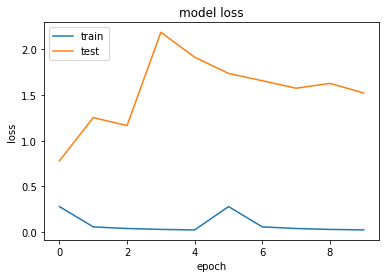

In [37]:
show_loss_plot(resnet_h1, resnet_h2)

In [38]:
# InceptionV3 200 finetune layer with BN 10 epoches
inceptionv3, inceptionv3_h1, inceptionv3_h2= run_a_model(InceptionV3, (299, 299), 200, 
                          preprocessing=inception_v3.preprocess_input, model_name_option='_BN_200_SGD_10epoche')

total layer count 311
Found 20864 images belonging to 10 classes.
Found 1560 images belonging to 10 classes.
Epoch 1/5
164/164 [==============================] - 476s - loss: 0.2441 - acc: 0.9346 - val_loss: 0.4646 - val_acc: 0.8218
Epoch 2/5
164/164 [==============================] - 466s - loss: 0.0368 - acc: 0.9878 - val_loss: 0.3760 - val_acc: 0.8712
Epoch 3/5
164/164 [==============================] - 466s - loss: 0.0262 - acc: 0.9921 - val_loss: 0.7321 - val_acc: 0.7891
Epoch 4/5
164/164 [==============================] - 466s - loss: 0.0240 - acc: 0.9928 - val_loss: 0.5207 - val_acc: 0.8429
Epoch 5/5
164/164 [==============================] - 466s - loss: 0.0179 - acc: 0.9941 - val_loss: 1.1483 - val_acc: 0.7647
Epoch 1/5
164/164 [==============================] - 468s - loss: 0.0222 - acc: 0.9944 - val_loss: 0.5619 - val_acc: 0.8673
Epoch 2/5
164/164 [==============================] - 463s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.4848 - val_acc: 0.8801
Epoch 3/5
164/164 [====

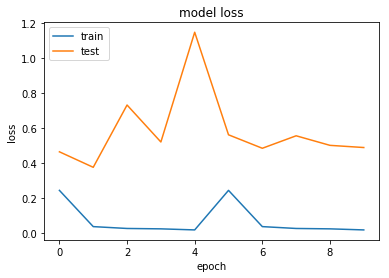

In [39]:
show_loss_plot(inceptionv3_h1, inceptionv3_h2)

优秀模型继续优化

In [6]:
run_a_model(VGG16, (224, 224), 15, model_name_option='_BN_15_SGD')

total layer count 19
Found 20864 images belonging to 10 classes.
Found 1560 images belonging to 10 classes.
Epoch 1/5
164/164 [==============================] - 385s - loss: 0.2480 - acc: 0.9271 - val_loss: 1.7392 - val_acc: 0.5641
Epoch 2/5
164/164 [==============================] - 341s - loss: 0.0405 - acc: 0.9893 - val_loss: 2.3495 - val_acc: 0.6333
Epoch 3/5
164/164 [==============================] - 341s - loss: 0.0246 - acc: 0.9930 - val_loss: 1.7060 - val_acc: 0.6218
Epoch 4/5
164/164 [==============================] - 341s - loss: 0.0138 - acc: 0.9964 - val_loss: 1.2859 - val_acc: 0.7218
Epoch 5/5
164/164 [==============================] - 341s - loss: 0.0073 - acc: 0.9977 - val_loss: 2.6110 - val_acc: 0.5994
Epoch 1/5
164/164 [==============================] - 342s - loss: 0.0079 - acc: 0.9974 - val_loss: 0.4301 - val_acc: 0.8827
Epoch 2/5
164/164 [==============================] - 340s - loss: 0.0078 - acc: 0.9978 - val_loss: 0.2986 - val_acc: 0.9282
Epoch 3/5
164/164 [=====

In [4]:
run_a_model(VGG16, (224, 224), 15, model_name_option='_BN_15_SGD_20e')

total layer count 19
Found 20864 images belonging to 10 classes.
Found 1560 images belonging to 10 classes.
Epoch 1/5
164/164 [==============================] - 603s - loss: 0.2486 - acc: 0.9283 - val_loss: 2.4089 - val_acc: 0.5801
Epoch 2/5
164/164 [==============================] - 337s - loss: 0.0393 - acc: 0.9889 - val_loss: 1.0648 - val_acc: 0.6955
Epoch 3/5
164/164 [==============================] - 337s - loss: 0.0212 - acc: 0.9943 - val_loss: 1.8312 - val_acc: 0.5647
Epoch 4/5
164/164 [==============================] - 337s - loss: 0.0141 - acc: 0.9958 - val_loss: 1.6120 - val_acc: 0.6782
Epoch 5/5
164/164 [==============================] - 337s - loss: 0.0099 - acc: 0.9969 - val_loss: 1.5405 - val_acc: 0.7071
Epoch 1/5
164/164 [==============================] - 338s - loss: 0.0067 - acc: 0.9982 - val_loss: 0.4048 - val_acc: 0.8929
Epoch 2/5
164/164 [==============================] - 336s - loss: 0.0057 - acc: 0.9987 - val_loss: 0.3907 - val_acc: 0.8942
Epoch 3/5
164/164 [=====

基础预测

In [7]:
from keras.models import load_model
model = load_model('models/model_VGG16_BN_15_SGD_20e.h5')

In [4]:
def get_img(path, image_shape):
    img = cv2.imread(path, 0)
    resized = cv2.resize(img, image_shape)
    return resized

def KNN(input_data, predictions, N=5, coef = [0.05, 0.1, 0.15, 0.2, 0.5]):
    new_predictions_list = []
    for i in tqdm(range(len(input_data))):
        distance = np.square(np.subtract(input_data, input_data[i]))
        distance = np.sqrt(np.sum(distance, axis=(1, 2)))
        N_min_index = np.argsort(distance)[::-1][-N:]
        
        pred = [ predictions[N_min_index[j]] * coef[j] for j in range(N)]
        pred = np.sum(pred, axis=0)
        new_predictions_list.append(pred)
                
    return np.array(new_predictions_list)

def make_predictions(MODEL, image_size, batch_size, preprocessing=None):
    gen = ImageDataGenerator(preprocessing_function=preprocessing)
    path_test_data = 'dataset/to_prediction'
    test_generator = gen.flow_from_directory(path_test_data,  image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode='categorical')
    y_predictions = MODEL.predict_generator(test_generator,  steps=test_generator.samples//batch_size+1,  verbose=1)
    # y_predictions = y_predictions.clip(min=0.005, max=0.995)
    
    test_id = list()
    for i, file_name in enumerate(test_generator.filenames):
        flbase = os.path.basename(file_name)
        test_id.append(flbase)       
    
    return y_predictions, test_id

def create_submission(predictions, test_id, tag = ""):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3',
                                                 'c4', 'c5', 'c6', 'c7',
                                                 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + tag + '.csv')
    result1.to_csv(sub_file, index=False)

In [9]:
y_predictions, test_id = make_predictions(model, (224, 224), 128)

Found 79726 images belonging to 1 classes.
623/623 [==============================] - 1756s  


In [22]:
new_predictions = y_predictions.clip(min=0.005, max=0.995)

In [10]:
create_submission(y_predictions, test_id, tag="VGG16_SGD_20e")